In [61]:
from DISPLAY import summarize_and_plot_total_cps, boxplot_cps
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [62]:
# selecionar n arquivos aleatórios na pasta do métodos escolhido
def selecionar_arquivos_aleatorios(diretorio, n):
    arquivos = os.listdir(diretorio)
    arquivos_ramdom = random.sample(arquivos, n)
    pares_cliente_servidor = [(arquivo.split('_')[0], arquivo.split('_')[1].replace('.csv','')) for arquivo in arquivos_ramdom]
    return pares_cliente_servidor

def selecionar_todos_os_arquivos(diretorio):
    arquivos = os.listdir(diretorio)
    pares_cliente_servidor = [(arquivo.split('_')[0], arquivo.split('_')[1].replace('.csv','')) for arquivo in arquivos]
    return pares_cliente_servidor

In [63]:
def calculate_cp_metrics_with_margin(source_dirs, ref_method, margin=3):
    variable = 'value'
    cp_col = f"{variable}_cp" 
    
    ref_dir = source_dirs[ref_method]
    test_methods = [m for m in source_dirs if m != ref_method]
    
    # Acumuladores globais
    metrics_summary = {
        method: {'TP': 0, 'FP': 0, 'FN': 0} for method in test_methods
    }

    for file in os.listdir(ref_dir):
        if not file.endswith(".csv"):
            continue
        
        try:
            df_ref = pd.read_csv(os.path.join(ref_dir, file))
        except Exception as e:
            print(f"Erro ao ler arquivo de referência {file}: {e}")
            continue

        gt_cps = set(df_ref.index[df_ref[cp_col] == 1])

        for method_name in test_methods:
            file_path_test = os.path.join(source_dirs[method_name], file)
            
            try:
                df_test = pd.read_csv(file_path_test)
            except FileNotFoundError:
                # Se não existir o arquivo de teste, pulamos (não contamos nada).
                continue
            except Exception as e:
                print(f"Erro ao ler arquivo de teste {file_path_test}: {e}")
                continue

            if cp_col not in df_test.columns:
                continue 
                    
            pred_cps = set(df_test.index[df_test[cp_col] == 1])
            
            matched_gt = set()    # GTs que já receberam pelo menos um previsto (cada GT conta no máximo 1 TP)
            matched_preds = set() # Preditos que já foram "consumidos/ignorados" por pertencerem a alguma margem
            tp = 0
            
            # Para cada GT, veja se há um ou mais previstos dentro da margem.
            # Se houver ≥1, conta 1 TP e marca TODOS os previstos dentro da margem para serem ignorados (não serão FP).
            for gt_cp in sorted(gt_cps):
                preds_in_margin = {p for p in pred_cps if abs(p - gt_cp) <= margin and p not in matched_preds}
                if preds_in_margin:
                    tp += 1
                    matched_gt.add(gt_cp)
                    # marca todos os previstos dentro da margem como "consumidos" (serão ignorados)
                    matched_preds.update(preds_in_margin)

            # Falsos positivos são os previstos que NÃO foram consumidos por nenhum GT
            fp = len(pred_cps - matched_preds)

            # Falsos negativos são os GTs que ficaram sem nenhum previsto dentro da margem
            fn = len(gt_cps - matched_gt)
                
            metrics_summary[method_name]['TP'] += tp
            metrics_summary[method_name]['FP'] += fp
            metrics_summary[method_name]['FN'] += fn

    final_results = []
    for method_name, counts in metrics_summary.items():
        TP, FP, FN = counts['TP'], counts['FP'], counts['FN']
        
        precision = 0.0 if (TP + FP == 0) else TP / (TP + FP)
        recall = 0.0 if (TP + FN == 0) else TP / (TP + FN)
        f1 = 0.0 if (precision + recall == 0) else 2 * (precision * recall) / (precision + recall)
        
        final_results.append({
            'Método': method_name,
            'Precision': f"{precision:.2%}",
            'Recall': f"{recall:.2%}",
            'F1-Score': f"{f1:.3f}",
            'Total_TP': TP,
            'Total_FP': FP,
            'Total_FN': FN
        })
    
    df_final = pd.DataFrame(final_results)
    print(f"\n--- Resultados da Comparação (vs Referência: {ref_method}, Margem: {margin} pontos) ---")
    print(df_final.to_string())
    
    return df_final


In [64]:
def plot_changepoint_comparison(source_dirs, client, server, variables, ref_method, ylim=None, save_fig=False):

    # --- 1. Mapeamento fixo de cores para métodos ---
    method_labels = list(source_dirs.keys())
    base_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_map = {}
    ref_label = ref_method
    non_ref_color_idx_map = 0

    for label in method_labels:
        if label == ref_label:
            color_map[label] = 'black'
        else:
            color_map[label] = base_colors[non_ref_color_idx_map % len(base_colors)]
            non_ref_color_idx_map += 1
    # ---------------------------------------------------

    for variable in variables:
        data_sources = {}
        for label, input_dir in source_dirs.items():
            file_path = os.path.join(input_dir, f"{client}_{server}.csv")
            if not os.path.exists(file_path):
                print(f"AVISO: Arquivo não encontrado para '{label}': {file_path}")
                continue

            try:
                df_temp = pd.read_csv(file_path)
                df_temp = df_temp.reset_index(drop=True)
                df_temp['idx'] = df_temp.index
                data_sources[label] = df_temp
            except Exception as e:
                print(f"Erro ao ler {file_path} para '{label}': {e}")

        if not data_sources:
            print(f"Nenhum dado carregado para {variable}. Pulando.")
            continue

        base_df = next(iter(data_sources.values()))

        if variable not in base_df.columns:
            print(f"AVISO: '{variable}' não está no arquivo. Pulando.")
            continue

        fig, ax = plt.subplots(figsize=(18, 6))

        # ---------------------------------------------------
        # Plot principal: linha azul default + marcador preto
        # ---------------------------------------------------
        ax.plot(
            base_df['idx'],
            base_df[variable],
            label=variable.capitalize(),
            color=base_colors[0],   # azul padrão do matplotlib
            marker='o',
            markersize=2,
            markerfacecolor='black',
            markeredgecolor='black',
            linewidth=1.2
        )

        y_values = base_df[variable].dropna()
        y_range = y_values.max() - y_values.min() if len(y_values) > 1 else 1
        gap = y_range * 0.05 if y_range > 0 else 1

        # ---------------------------------------------------
        # Changepoints
        # ---------------------------------------------------
        non_ref_methods_in_order = [m for m in method_labels if m != ref_label]

        for label in method_labels:
            df = data_sources.get(label)
            if df is None:
                continue

            cp_col = f"{variable}_cp"
            if cp_col not in df.columns:
                continue

            cp_data = df[df[cp_col] == 1]

            if cp_data.empty:
                continue

            # Referência = linhas verticais
            if label == ref_label:
                for cp_idx in cp_data['idx']:
                    ax.axvline(cp_idx, color='black', linestyle='--', label="CP Real")
                continue

            # Não referência = pontos deslocados
            k = non_ref_methods_in_order.index(label)
            offset = ((-1)**(k + 1)) * ((k + 1) // 2)

            y_adj = cp_data[variable] + offset * gap

            ax.plot(
                cp_data['idx'],
                y_adj,
                linestyle='None',
                marker='o',
                markersize=10,
                color=color_map[label],
                label=f"CP {label}"
            )

        # ---------------------------------------------------
        # Ajustes finais
        # ---------------------------------------------------
        ax.set_title(f"Comparativo de Changepoints para '{variable}'\nCliente: {client} | Servidor: {server}")
        ax.set_xlabel("Índice")
        ax.set_ylabel(variable)
        ax.grid(True, linestyle='--', linewidth=0.5)
        ax.legend()

        if ylim:
            ax.set_ylim(ylim)

        if save_fig:
            output_dir = "imgs_comparativo"
            os.makedirs(output_dir, exist_ok=True)
            file = os.path.join(output_dir, f"COMP_{client}_{server}_{variable}.png")
            plt.savefig(file, dpi=150, bbox_inches='tight')
            print(f"Figura salva em: {file}")

        plt.show()


In [65]:
cenario = 'cenario_2b'
cenario = 'teste_m5'
DIRS_PARA_COMPARAR = {
    'CuSum': f'changepoints/{cenario}/cusum',
    'PELT-NP': f'changepoints/{cenario}/pelt',
    'VWCD linear': f'changepoints/{cenario}/linear',
    'VWCD Multiplicativa': f'changepoints/{cenario}/multiplicativa',
    'VWCD logaritmica U': f'changepoints/{cenario}/logaritmica_U',
    'VWCD otima U': f'changepoints/{cenario}/otima_U',
    'VWCD logaritmica H': f'changepoints/{cenario}/logaritmica_H',
    'VWCD otima H': f'changepoints/{cenario}/otima_H',
    'Label': f'time_series/{cenario}',
}

VARIABLES = ['value']

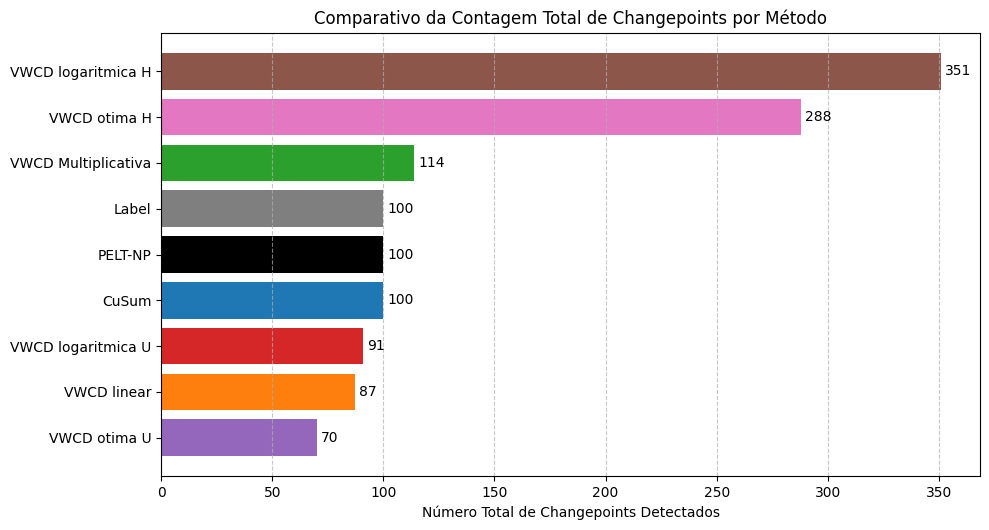

In [66]:
summarize_and_plot_total_cps(DIRS_PARA_COMPARAR)

In [67]:
calculate_cp_metrics_with_margin(
    source_dirs=DIRS_PARA_COMPARAR,
    ref_method='Label',
    margin=10
);



--- Resultados da Comparação (vs Referência: Label, Margem: 10 pontos) ---
                Método Precision   Recall F1-Score  Total_TP  Total_FP  Total_FN
0                CuSum    73.00%   73.00%    0.730        73        27        27
1              PELT-NP   100.00%  100.00%    1.000       100         0         0
2          VWCD linear    89.66%   78.00%    0.834        78         9        22
3  VWCD Multiplicativa    80.70%   92.00%    0.860        92        22         8
4   VWCD logaritmica U    89.01%   81.00%    0.848        81        10        19
5         VWCD otima U    92.86%   65.00%    0.765        65         5        35
6   VWCD logaritmica H    24.07%   84.00%    0.374        84       265        16
7         VWCD otima H    26.92%   77.00%    0.399        77       209        23


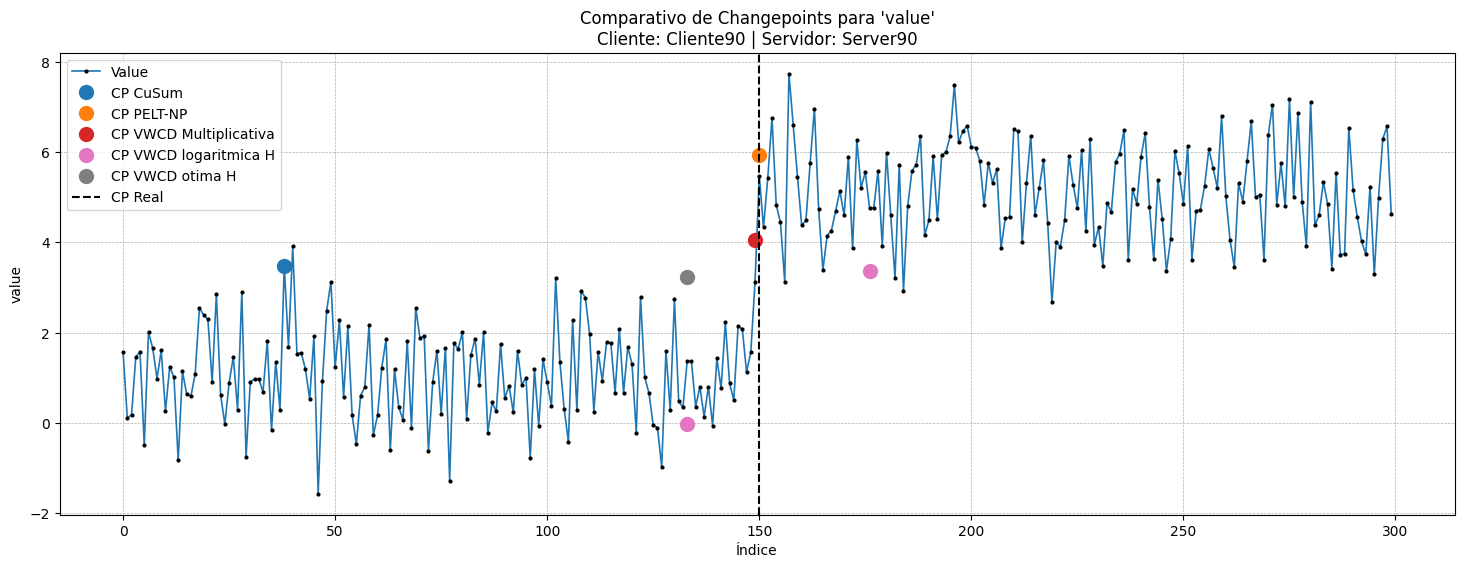

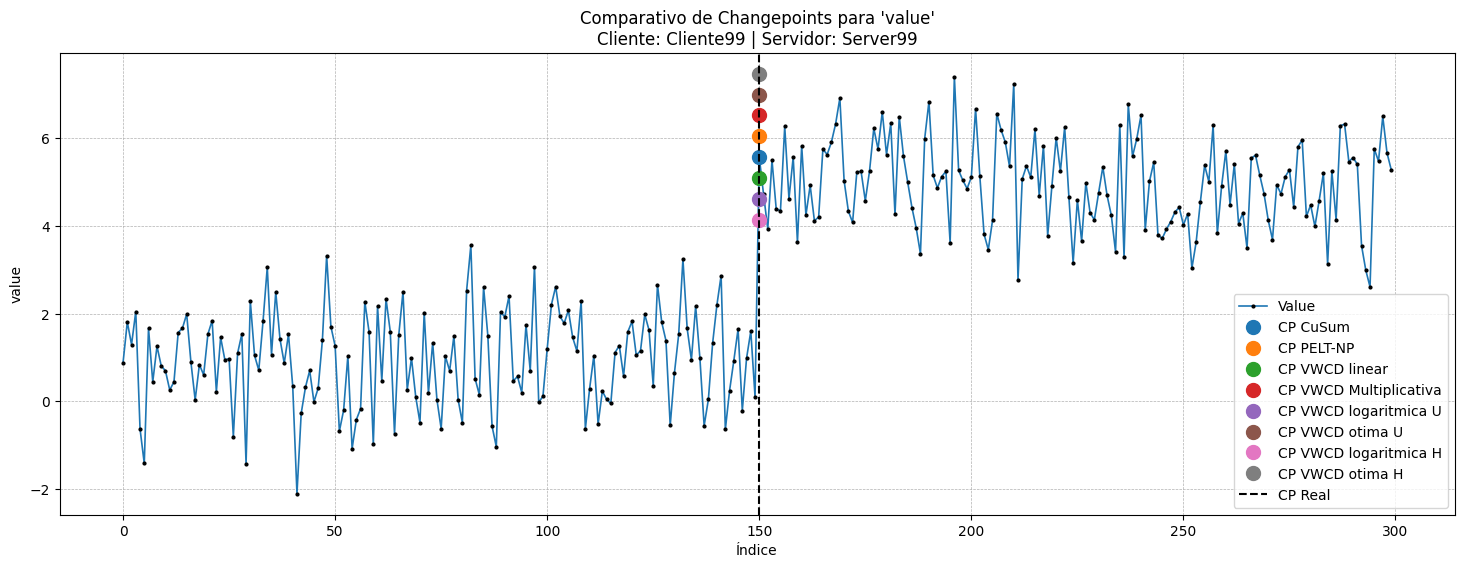

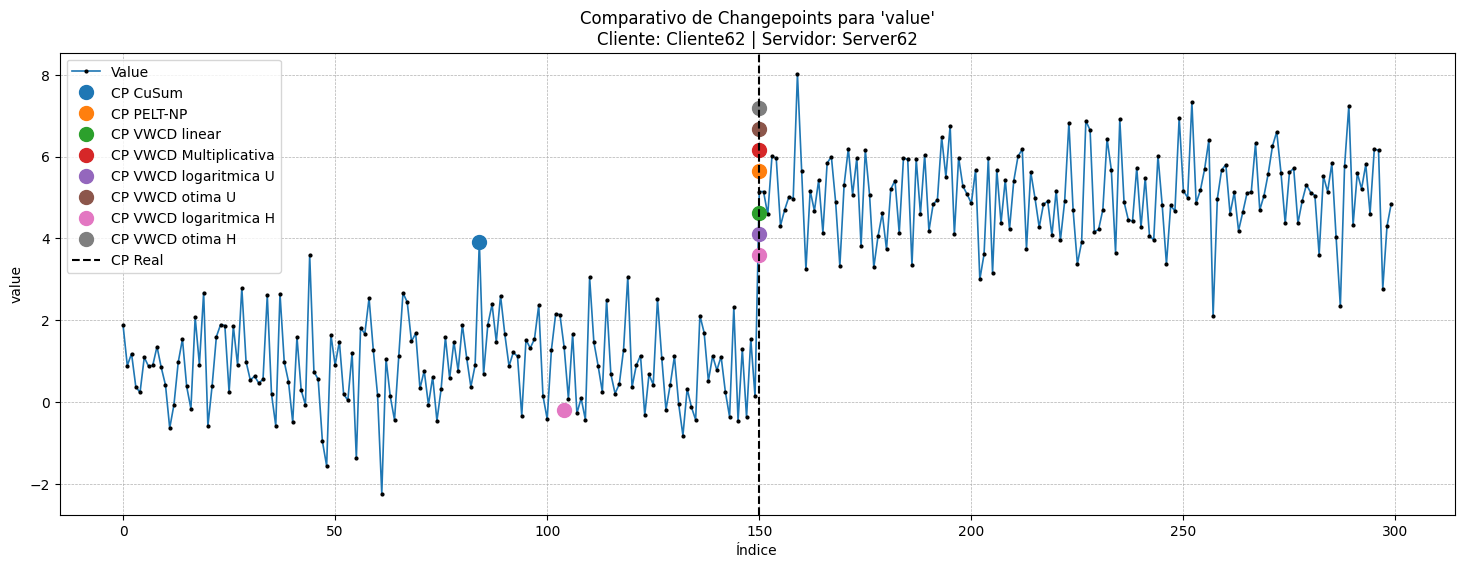

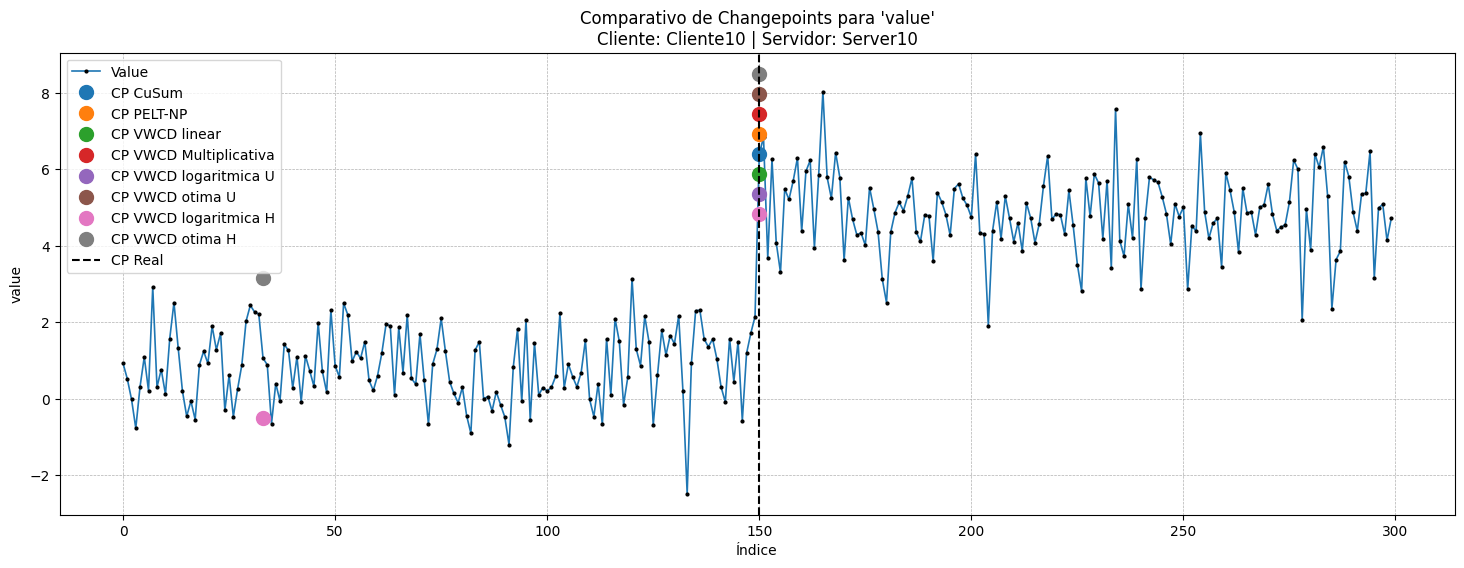

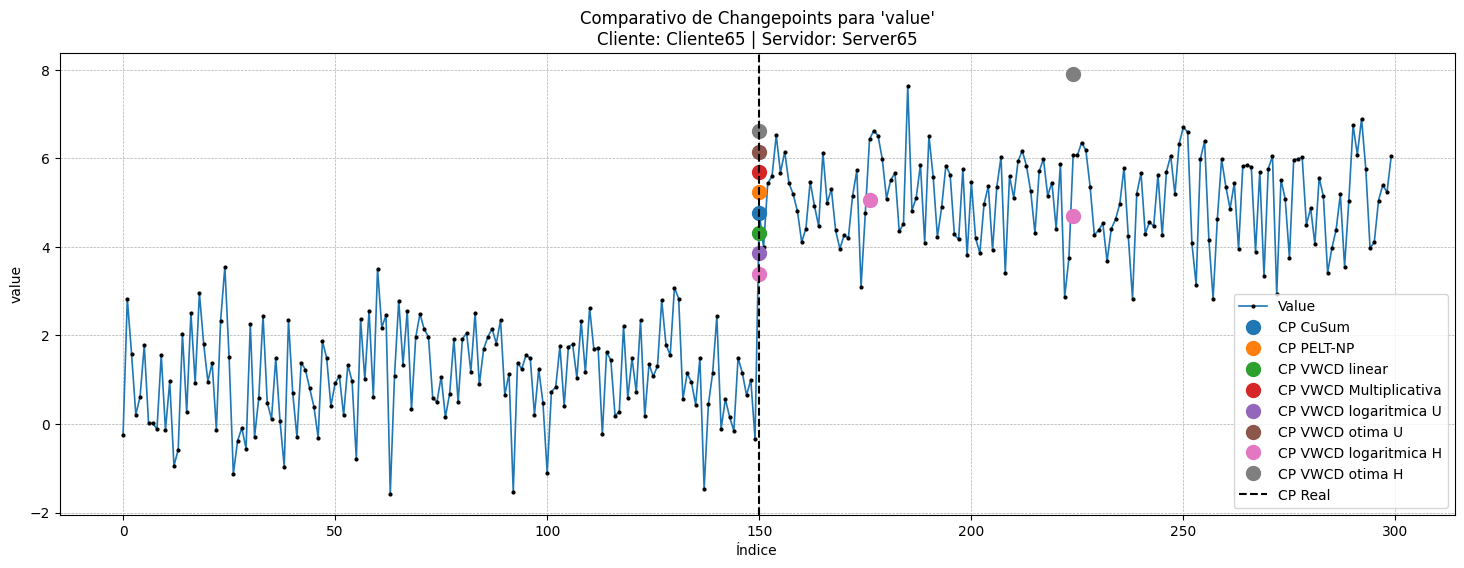

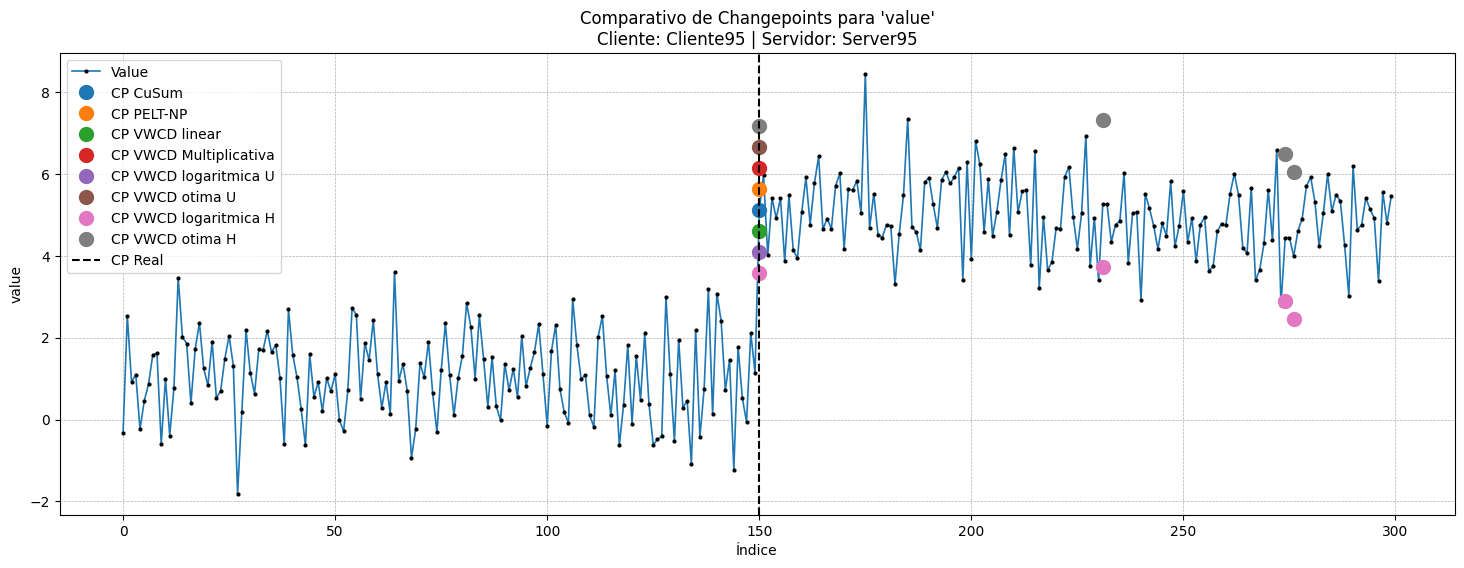

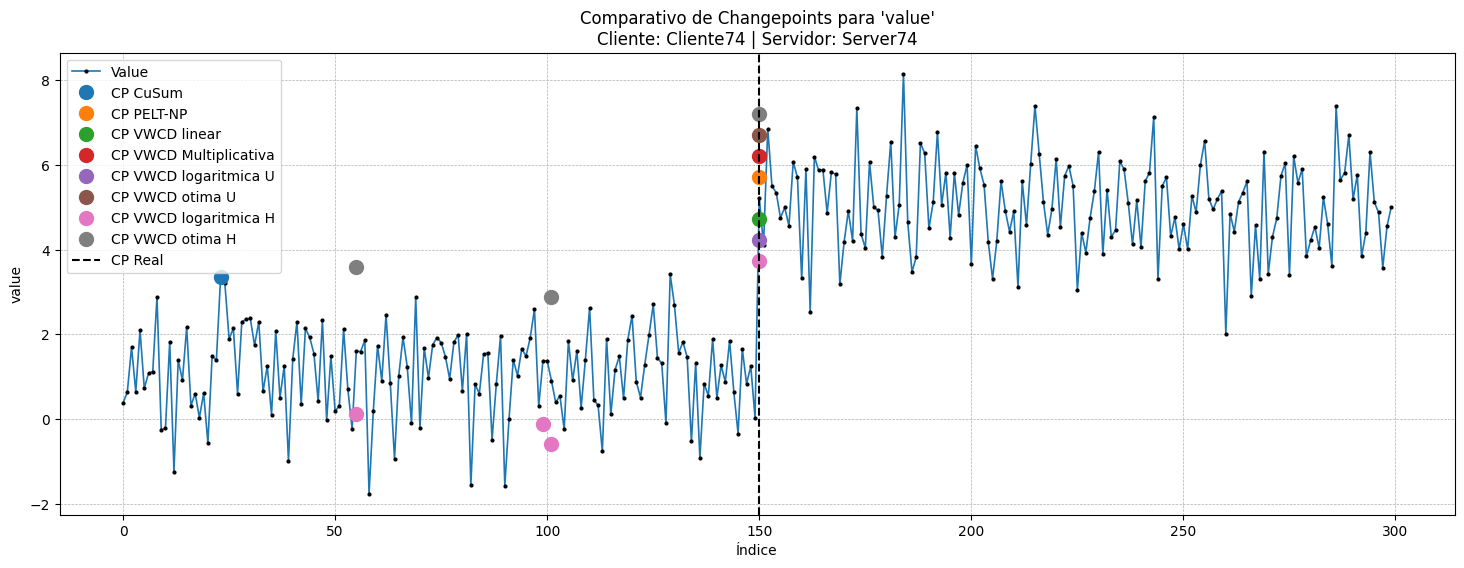

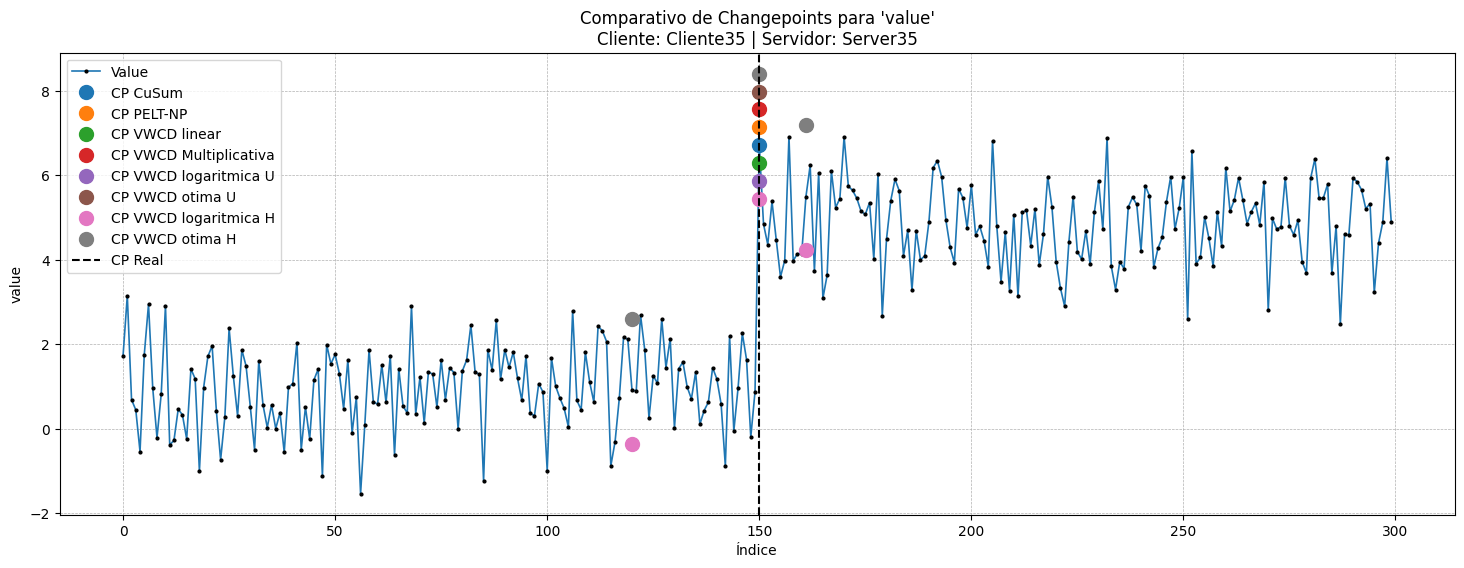

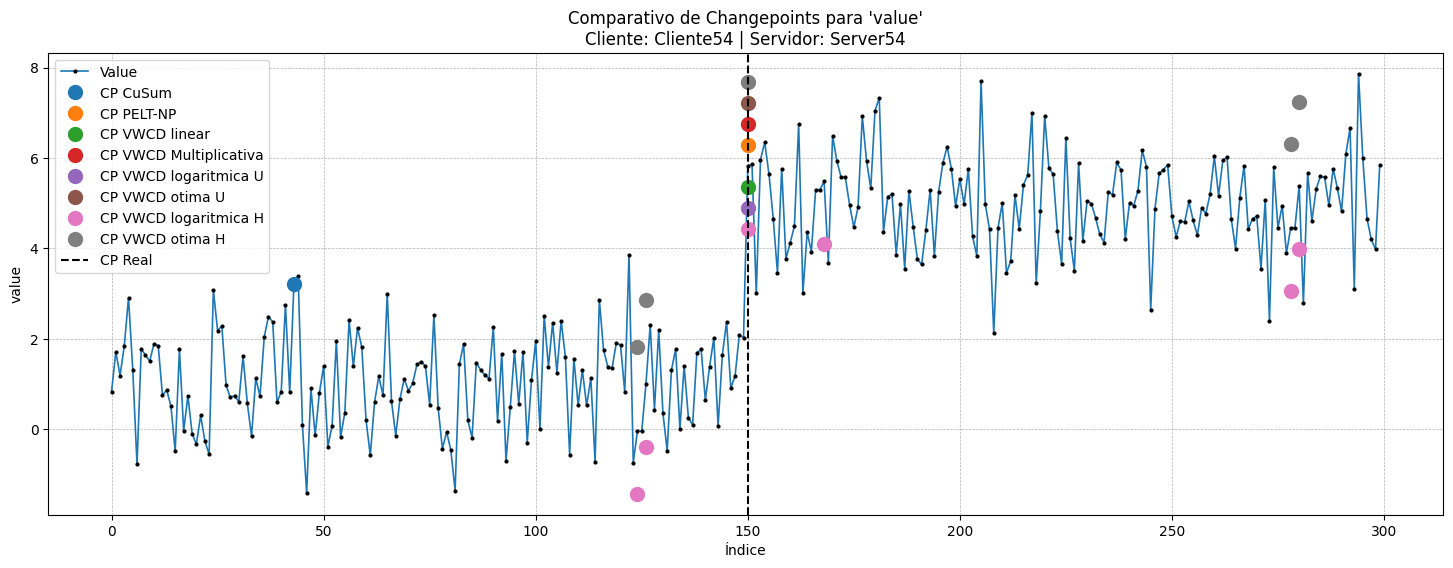

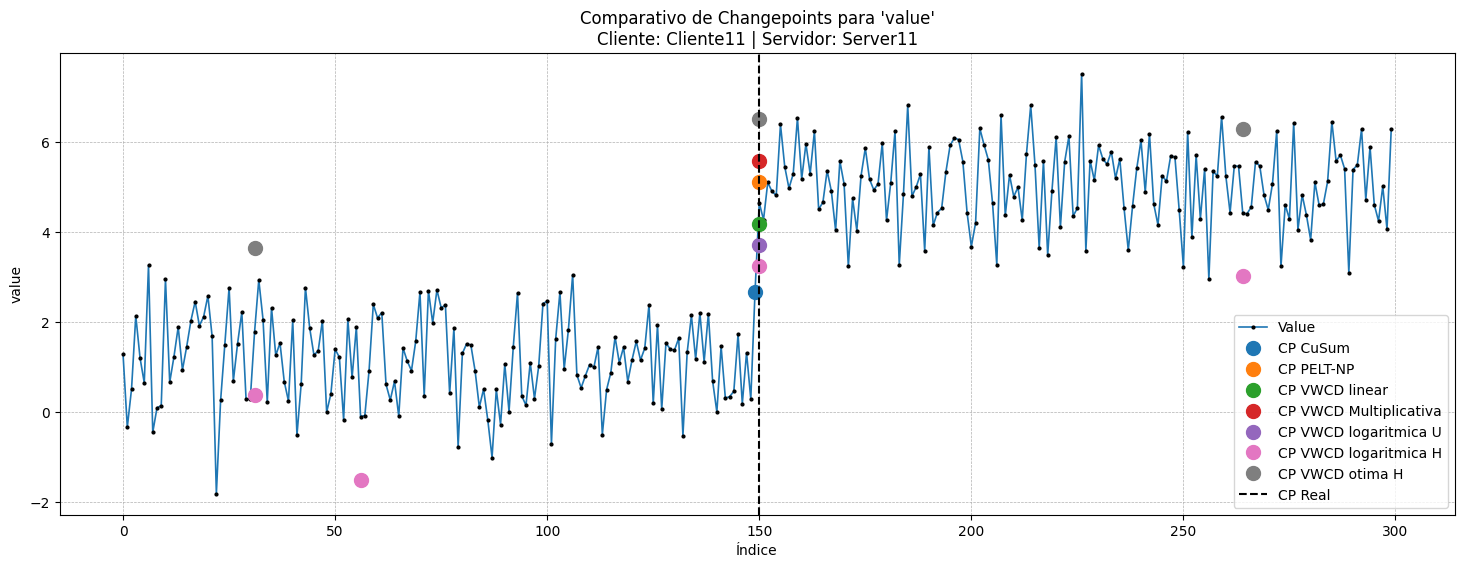

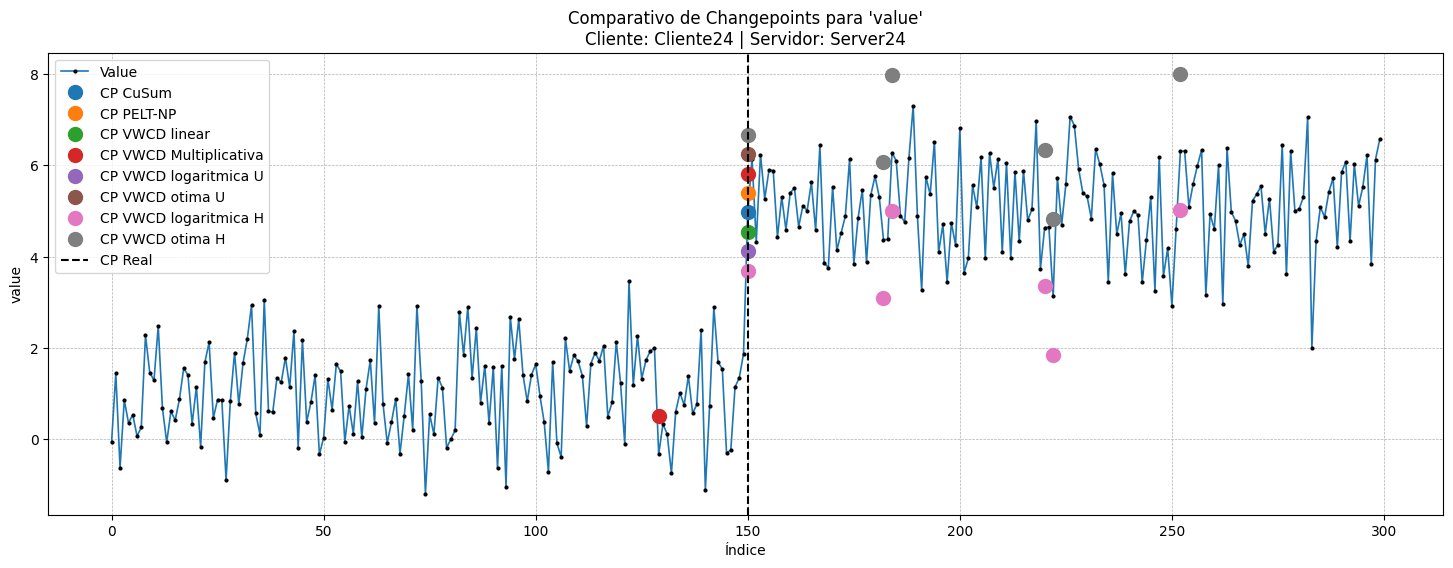

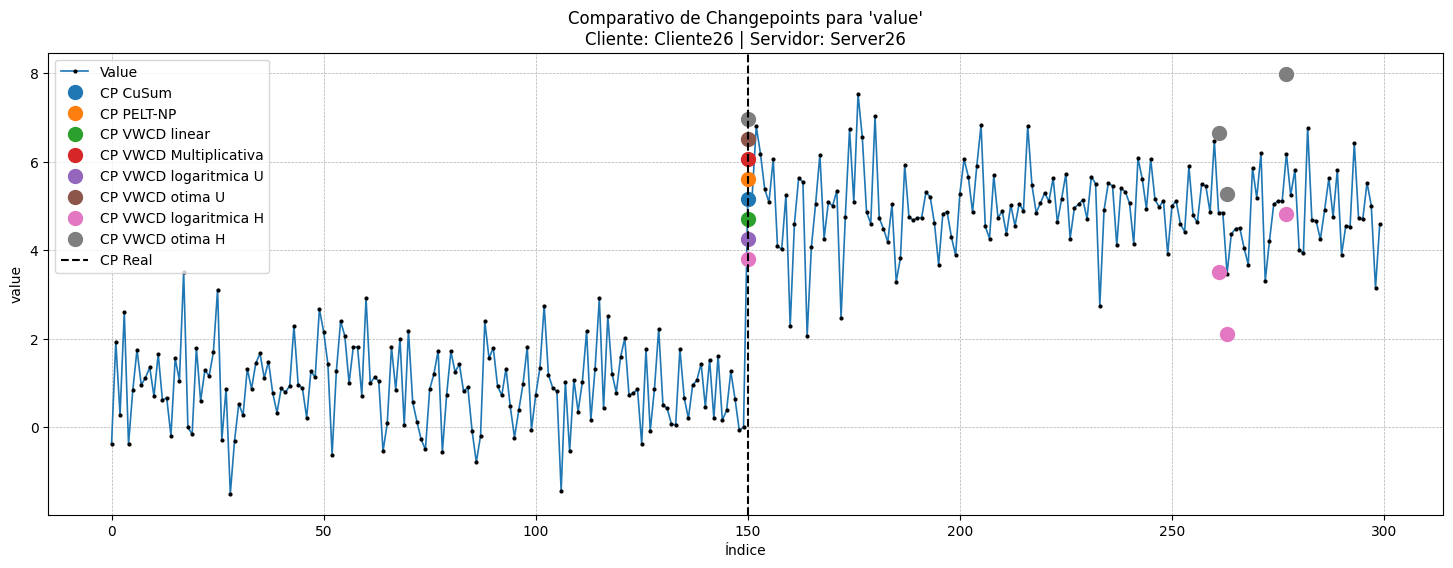

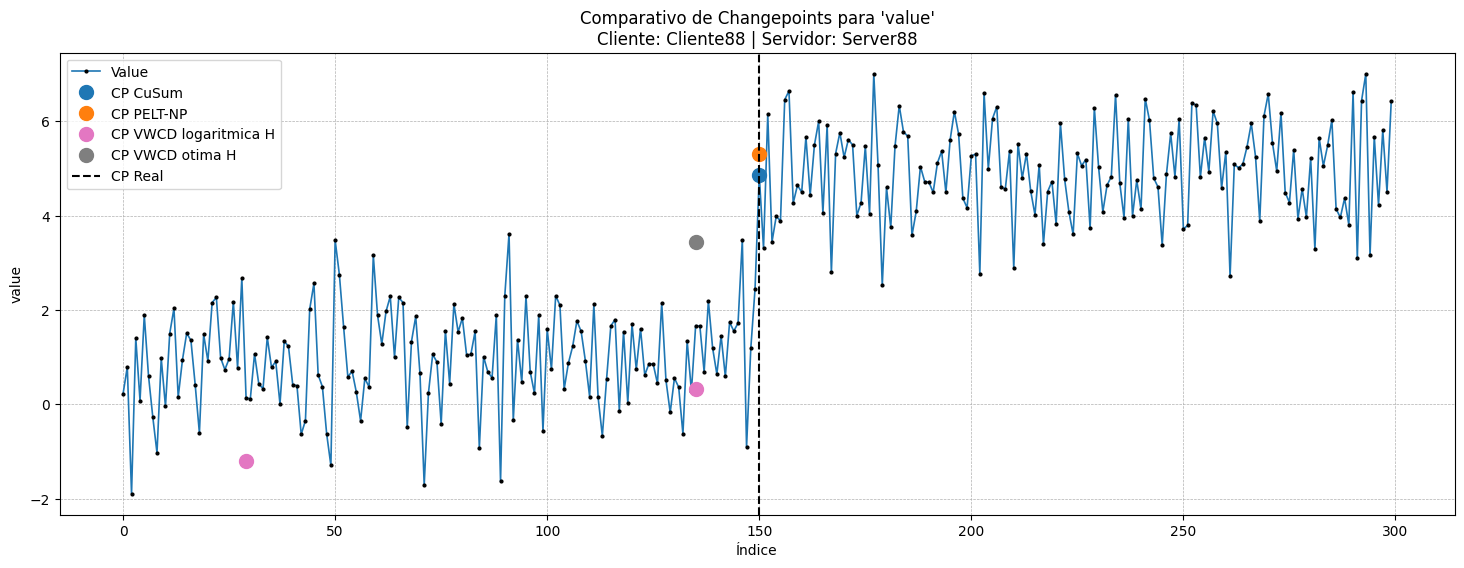

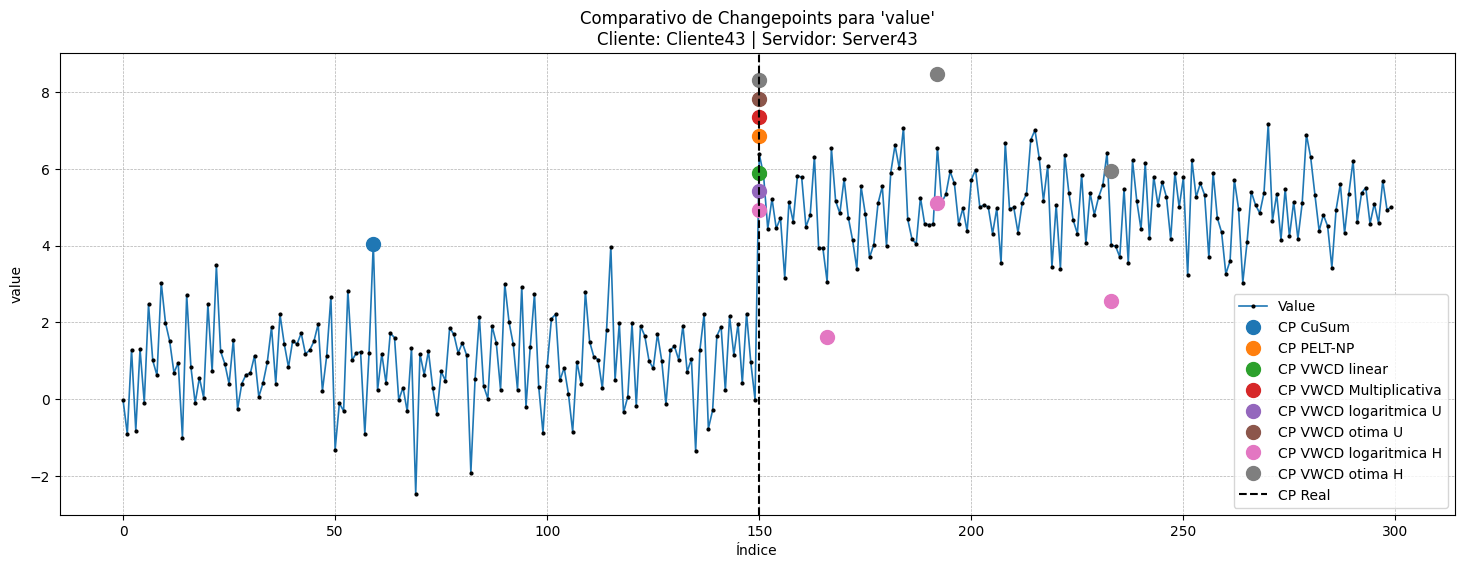

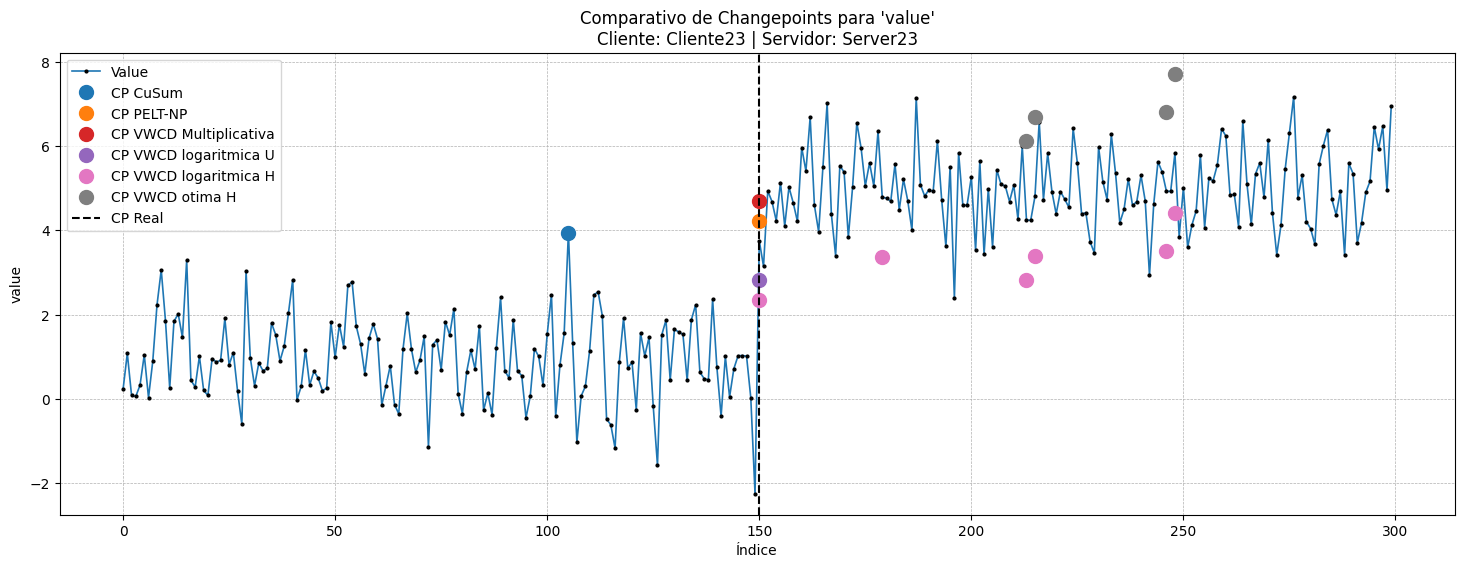

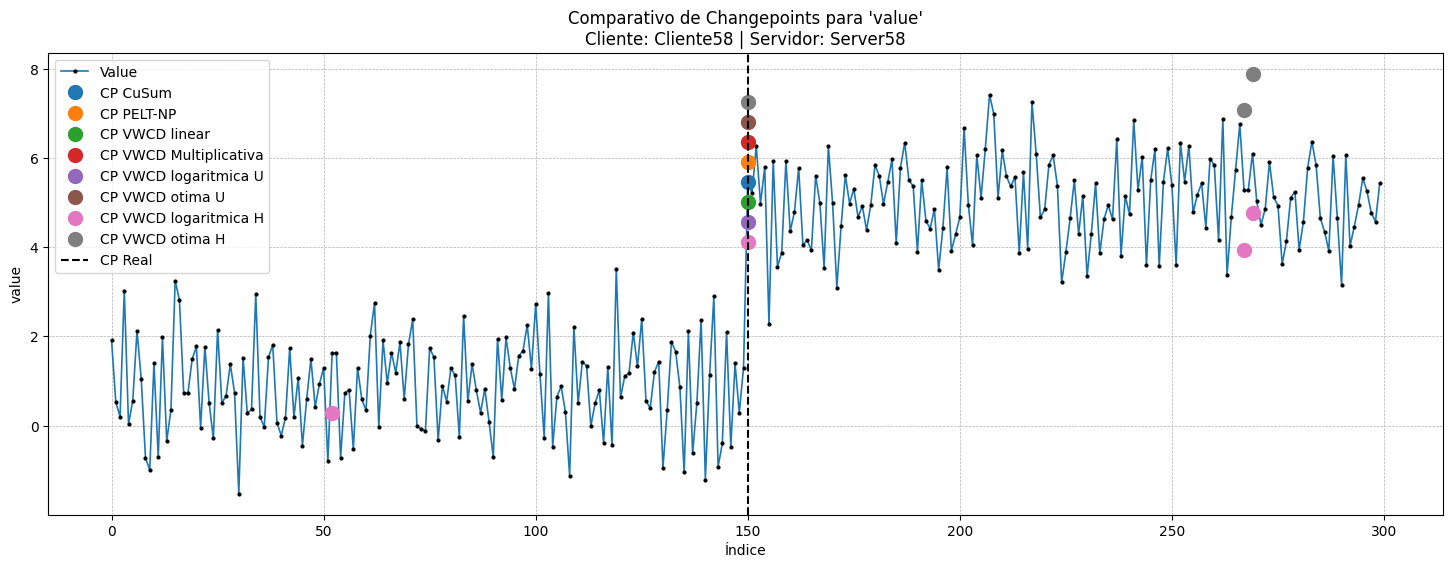

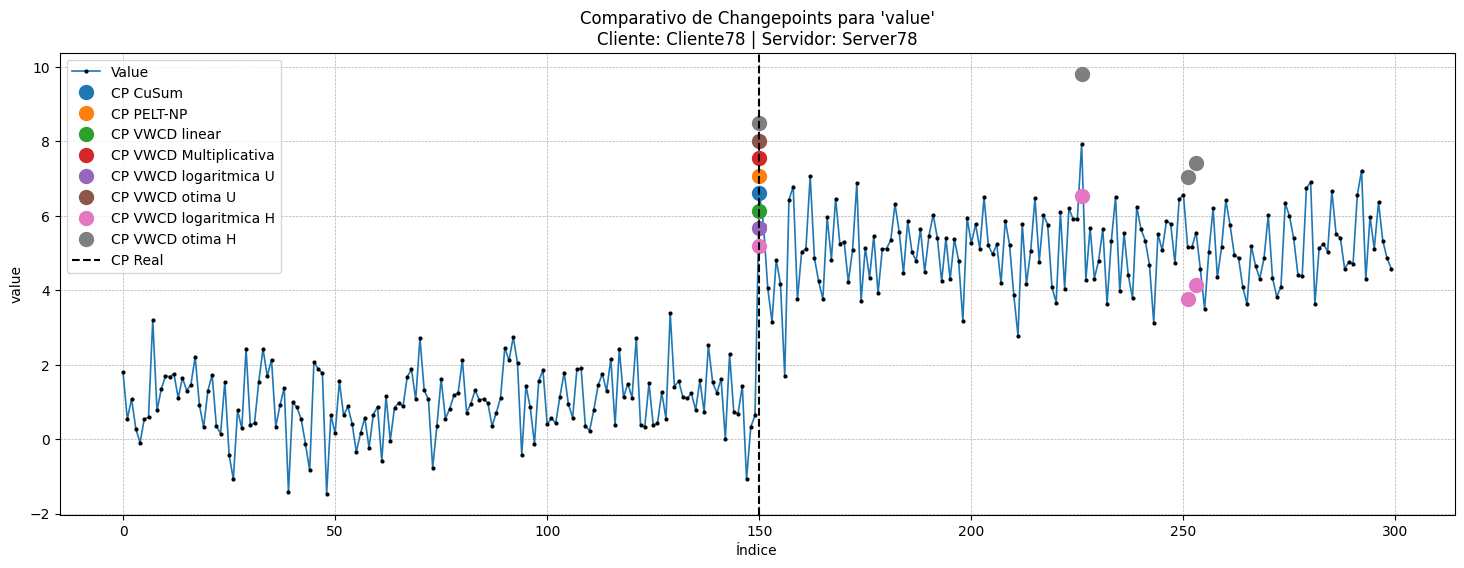

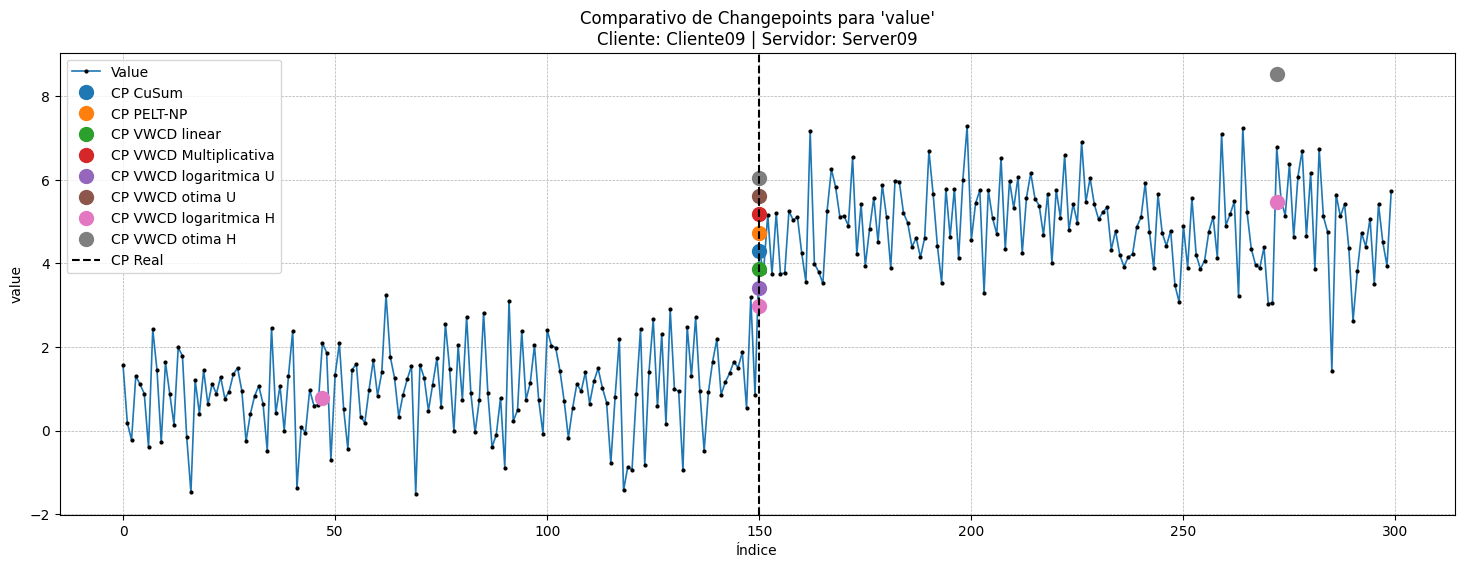

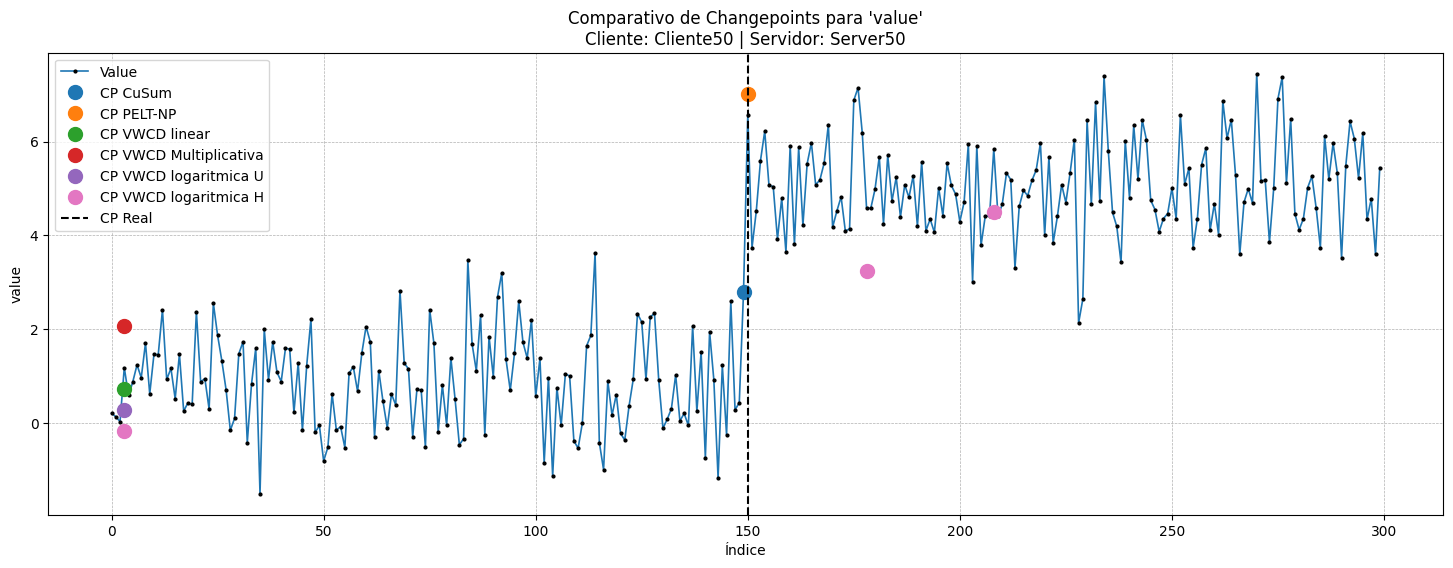

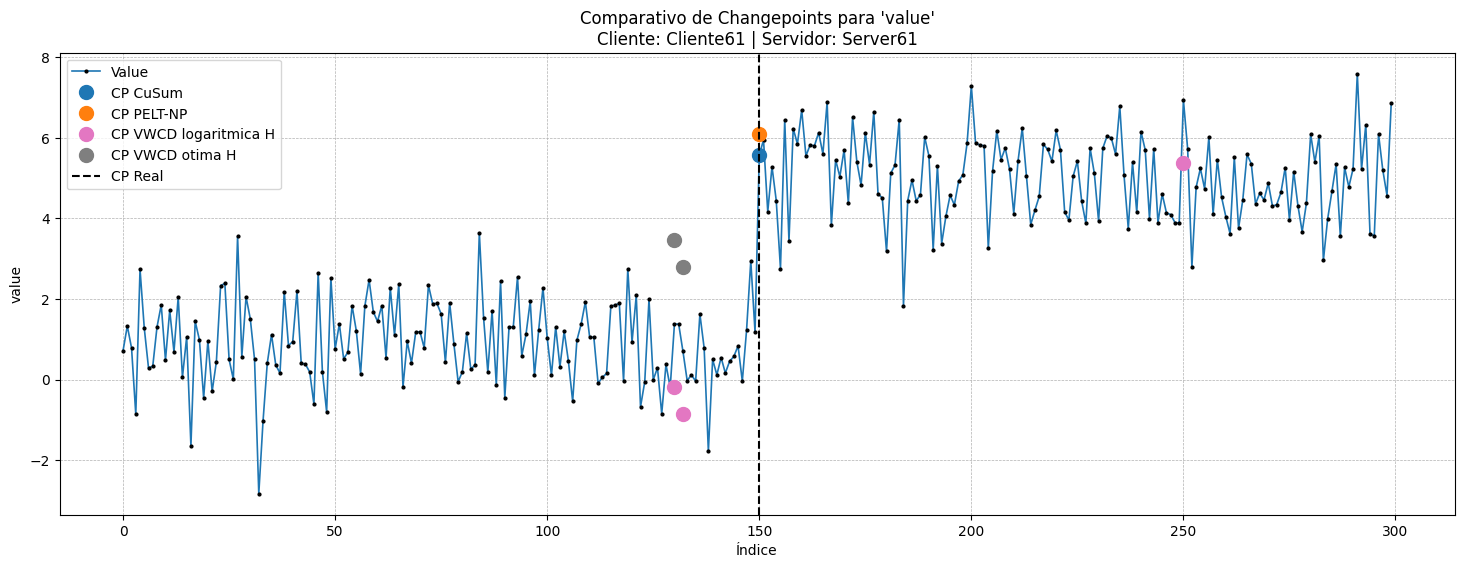

In [68]:
# pares = selecionar_todos_os_arquivos(DIRS_PARA_COMPARAR['Label'])
pares = selecionar_arquivos_aleatorios(DIRS_PARA_COMPARAR['Label'], 20)

for client, server in pares:
    plot_changepoint_comparison(
        source_dirs=DIRS_PARA_COMPARAR,
        client=client,
        server=server,
        variables=VARIABLES,
        save_fig=False,
        ref_method='Label'
    )